In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from lmfit import Model
import plotly.express as px
import scipy.stats as stats
from tqdm.notebook import tqdm
from IPython.display import Image 

## Энергия
Построим графики полной энергии системы, кинетической и потенциальной. На них можно видеть, что полная энергия остается постоянной, в процессе релаксации часть кинетической энергии переходит в потенциальную, после чего система переходит в состояние равновесия. Данные получены для $N=4096$ частиц.

In [5]:
energy = pd.read_csv("energy/energy.csv")
energy['Error'] = energy.apply(lambda row: (row.Total-energy['Total'][0])/energy['Total'][0], axis=1)

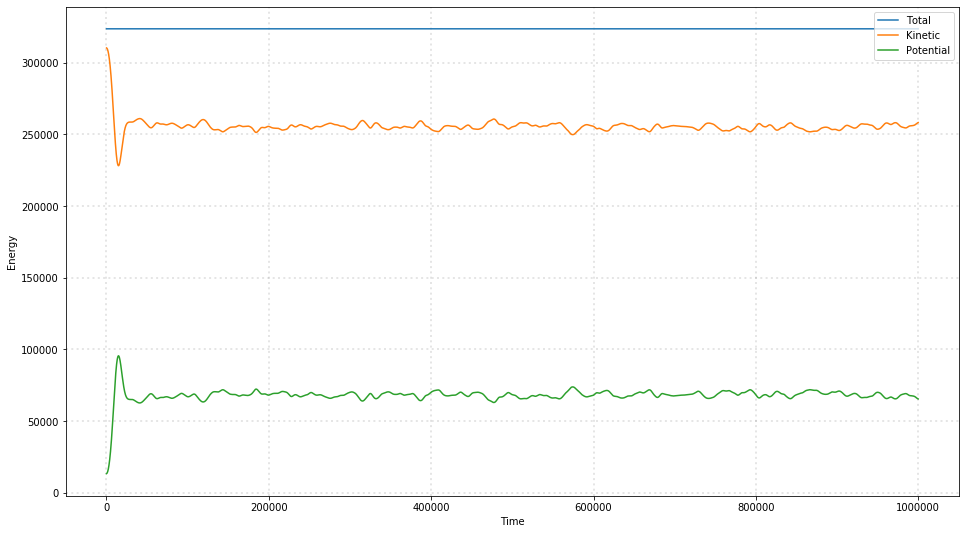

In [7]:
plt.plot(energy['t'], energy['Total'], label = 'Total')
plt.plot(energy['t'], energy['Kinetic'], label = 'Kinetic' )
plt.plot(energy['t'], energy['Potential'], label = 'Potential')
plt.rcParams['figure.figsize'] = [16, 9]
plt.grid(b=True, color='Grey', alpha=0.2, linestyle=':', linewidth=2)
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend(loc="upper right")
plt.show()

## Колебания полной энергии
Из-за точности вычислений энергия не является в точности постоянной и флуктуирует в порядке $10^{-5}$ (для шага интегрирования $10^{-6}$ единиц Леннарда-Джонса (reduced units)). Это считается достаточной точностью. Данные получены для $N=4096$ частиц

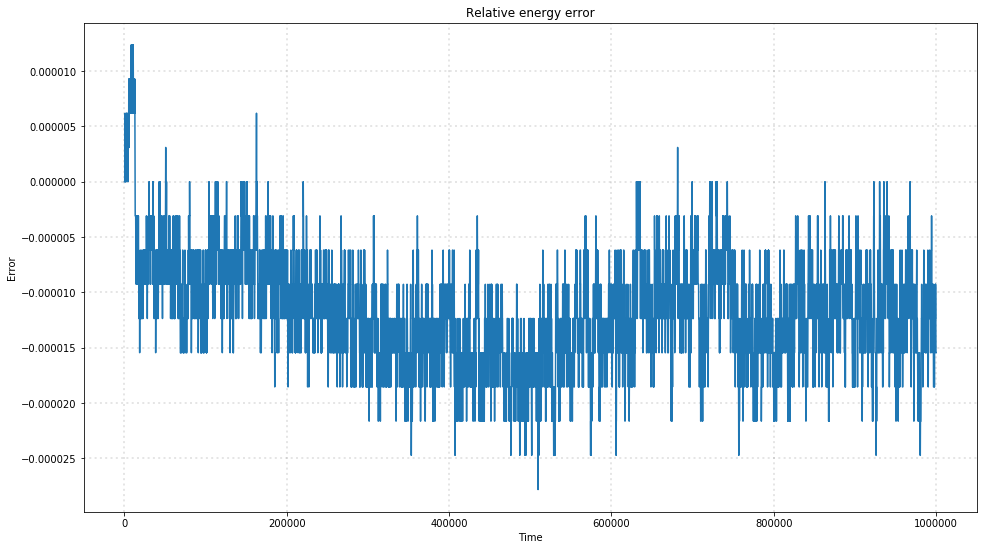

In [10]:
plt.plot(energy['t'], energy['Error'])
plt.rcParams['figure.figsize'] = [16, 9]
plt.grid(b=True, color='Grey', alpha=0.2, linestyle=':', linewidth=2)
plt.xlabel("Time")
plt.ylabel("Error")
plt.title("Relative energy error")
plt.show()

In [11]:
print("Std of total energy: " + str(energy['Total'].std()))
print("Variation of total energy: " + str(energy['Total'].std()/energy['Total'].mean()))

Std of total energy: 1.6126459301584781
Variation of total energy: 4.982558417180366e-06


## Распределение скоростей
Для жидкости из $N=4096$ частиц, температуры $T=2.0$ (по средней кинетической энергии) и плотности $\rho=1.0$, построим распределение скоростей в равновесном состоянии. Можно увидеть, что скорости соответствуют распределению Максвелла. (Для этой же симуляции ниже приведена радиальная функция распределения).

Произведя фит модуля скорости распределением Максвелла, получим, что распределение соответствует температуре 2.0 (reduced units), что соответствует средней кинетической энергии.

Так же, построив график логарифма числа частиц от квадрата скорости, проверим, что распределение скоростей по оси так же описывается распределением Максвелла, так как этот график линеен.

In [2]:
df = pd.read_csv("rdf/liquid3.dat", sep=' ', names= ['x','y','z','vx','vy','vz','1','2','3','4','5','6','7','8'])
del df['1'], df['2'], df['3'], df['4'], df['5'], df['6'], df['7'], df['8']

In [3]:
df['v'] = df.apply(lambda row: np.sqrt(row.vx*row.vx+row.vy*row.vy+row.vz*row.vz), axis=1)

Text(0.5, 1.0, 'v')

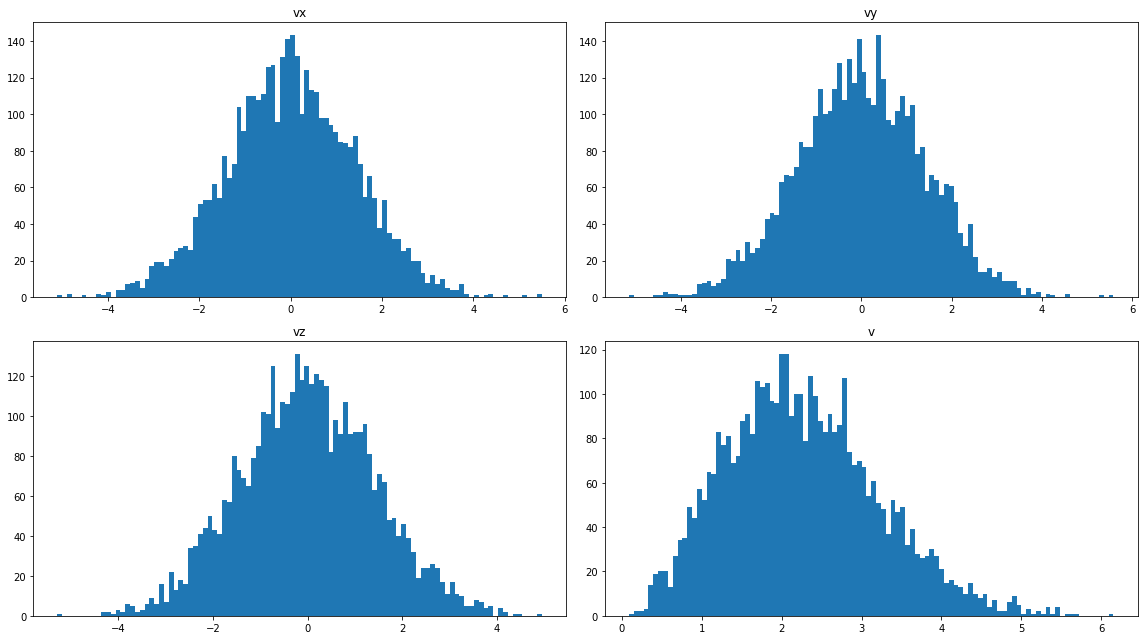

In [8]:
fig, axs = plt.subplots(2, 2, tight_layout=True)
axs[0, 0].hist(df['vx'], bins=100)
axs[0, 0].set_title("vx")
axs[0, 1].hist(df['vy'], bins=100)
axs[0, 1].set_title("vy")
axs[1, 0].hist(df['vz'], bins=100)
axs[1, 0].set_title("vz")
axs[1, 1].hist(df['v'], bins=100)
axs[1, 1].set_title("v")

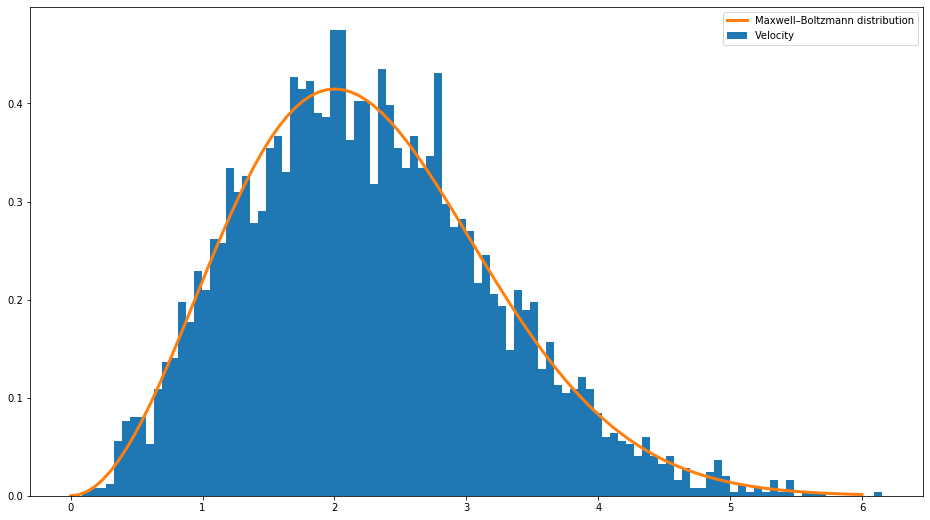

T=2.003637757490558


In [9]:
maxwell = stats.maxwell
data = maxwell.rvs(loc=0, scale=1, size=10000)
params = maxwell.fit(df['v'], floc=0)
plt.hist(df['v'], bins=100, density=True, label='Velocity')
x = np.linspace(0, 6, 100)
plt.plot(x, maxwell.pdf(x, *params), lw=3, label = "Maxwell–Boltzmann distribution")
plt.legend()
plt.show()
print('T='+str(params[1]**2))

Text(0, 0.5, 'Count')

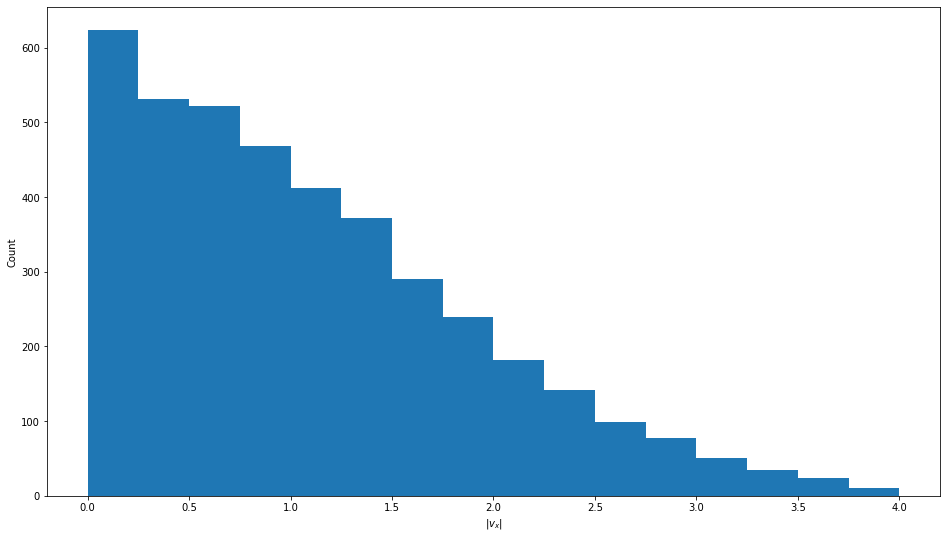

In [66]:
df['vx_abs'] = df.apply(lambda row: abs(row.vx), axis=1)
counts, bins, bars = plt.hist(df['vx_abs'], bins=16, range=(0,4))
plt.xlabel(r"$|v_{x}|$")
plt.ylabel(r"Count")

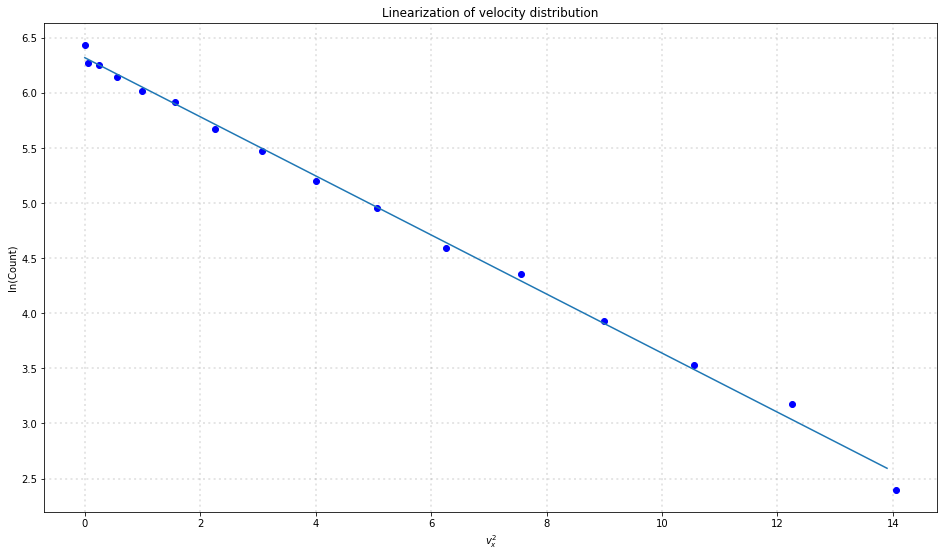

In [71]:
plt.plot(bins[0:-1]**2, np.log(counts), "bo")
a, b = np.polyfit(bins[0:-1]**2, np.log(counts), 1)
plt.plot(np.arange(0, 14, 0.1), np.arange(0, 14, 0.1)*a+b)
plt.rcParams['figure.figsize'] = [16, 9]
plt.grid(b=True, color='Grey', alpha=0.2, linestyle=':', linewidth=2)
plt.xlabel(r"$v_{x}^{2}$")
plt.ylabel(r"ln(Count)")
plt.title("Linearization of velocity distribution")
plt.show()

## RDF
Построим радиальные функции распределения для нескольких систем, описываемых потенциалом Леннарда-Джонса.
Радиальные функции разпределения получены для: 
* твердого тела (fcc-решетка): $ N=2048 \quad T=1.5 \quad \rho=1.2 $ 
* жидкости: $N=4096 \quad T=2.0 \quad \rho=1.0$ 
* газа: $N=4096 \quad T=30.0 \quad \rho=0.7$ 

Можно увидеть, что функции имеют вид, совпадающий с теоретическим. Зависимости сняты для ограниченного числа молекул, поэтому не являются гладкими

### Твердое тело
RDF имеет пики на $ 1, \sqrt{2}, \sqrt{3} ...$ соответствующие положениям молекул в решетке и равна нулю между ними

In [12]:
df = pd.read_csv("rdf/fcc.dat", sep=' ', names= ['x','y','z','vx','vy','vz','1','2','3','4','5','6','7','8'])
del df['1'], df['2'], df['3'], df['4'], df['5'], df['6'], df['7'], df['8']

In [13]:
dr = 0.03
r = np.arange(0, 3.0, dr)
rho = 1.2
particles = 2048
cell = 11.950412657
g = np.zeros(len(r))
x = np.array(df['x'])
y = np.array(df['y'])
z = np.array(df['z'])
for n in tqdm(range(0,particles), desc="Points"):
    x0=x[n]
    y0=y[n]
    z0=z[n]
    rx = x0 - x
    ry = y0 - y
    rz = z0 - z
    rx -= np.rint(rx/cell)*cell
    ry -= np.rint(ry/cell)*cell
    rz -= np.rint(rz/cell)*cell
    rt = np.sqrt(rx*rx+ry*ry+rz*rz)
    rt = np.trunc(rt/dr)
    for j in rt:
        if j<len(g) and j>1:
            rc = j*dr
            g[int(j)]+=1/(4*rho*np.pi*rc*rc*dr)

g = g/particles

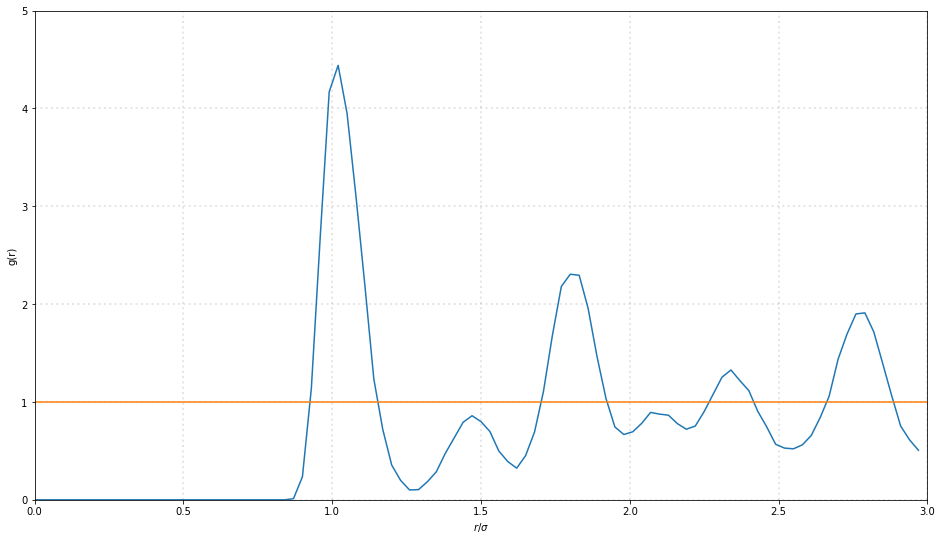

In [14]:
plt.plot(r, g)
plt.plot(np.arange(0, 4, 1), np.ones(4))
plt.rcParams['figure.figsize'] = [16, 9]
plt.grid(b=True, color='Grey', alpha=0.2, linestyle=':', linewidth=2)
plt.xlabel(r"$r/\sigma$")
plt.ylabel("g(r)")
plt.ylim(0,5)
plt.xlim(0,3)
plt.show()

### Жидкость
RDF имеет некоторые пики, соответствующие группам молекул в жидкости и достаточно быстро выходит на единицу

In [20]:
df = pd.read_csv("rdf/liquid3.dat", sep=' ', names= ['x','y','z','vx','vy','vz','1','2','3','4','5','6','7','8'])
del df['1'], df['2'], df['3'], df['4'], df['5'], df['6'], df['7'], df['8']

In [21]:
dr = 0.04
r = np.arange(0, 8.0, dr)
g = np.zeros(len(r))
x = np.array(df['x'])
y = np.array(df['y'])
z = np.array(df['z'])
for n in tqdm(range(4096), desc="Points"):
    x0=x[n]
    y0=y[n]
    z0=z[n]
    rx = x0 - x
    ry = y0 - y
    rz = z0 - z
    rx -= np.rint(rx/16.0)*16.0
    ry -= np.rint(ry/16.0)*16.0
    rz -= np.rint(rz/16.0)*16.0
    rt = np.sqrt(rx*rx+ry*ry+rz*rz)
    rt = np.trunc(rt/dr)
    for j in rt:
        if j<len(g) and j>1:
            rc = j*dr
            g[int(j)]+=1/(4*np.pi*rc*rc*dr)

g = g/4096

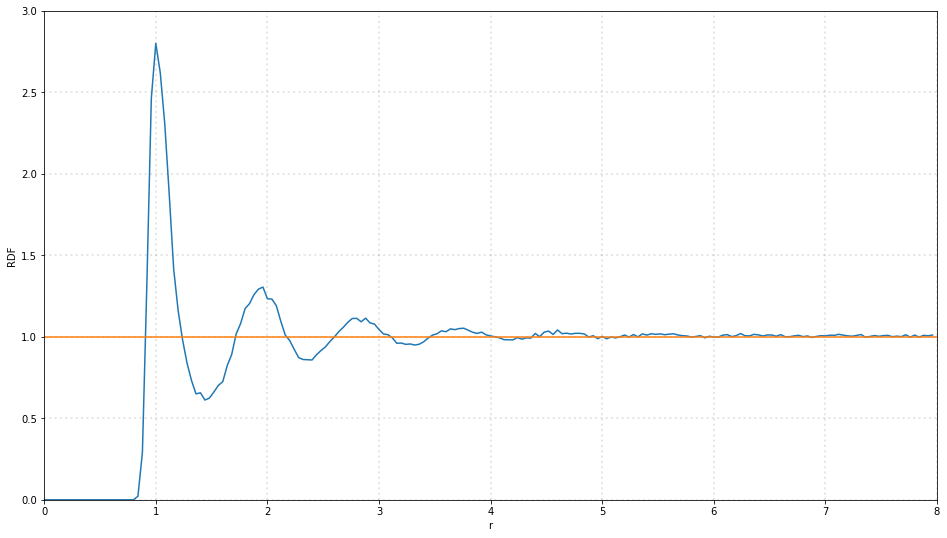

In [22]:
plt.plot(r, g)
plt.plot(np.arange(0, 9, 1), np.ones(9))
plt.rcParams['figure.figsize'] = [16, 9]
plt.grid(b=True, color='Grey', alpha=0.2, linestyle=':', linewidth=2)
plt.xlabel("r")
plt.ylabel("RDF")
plt.ylim(0,3)
plt.xlim(0,8)
plt.show()

То же самое, полученное при помощи OVITO

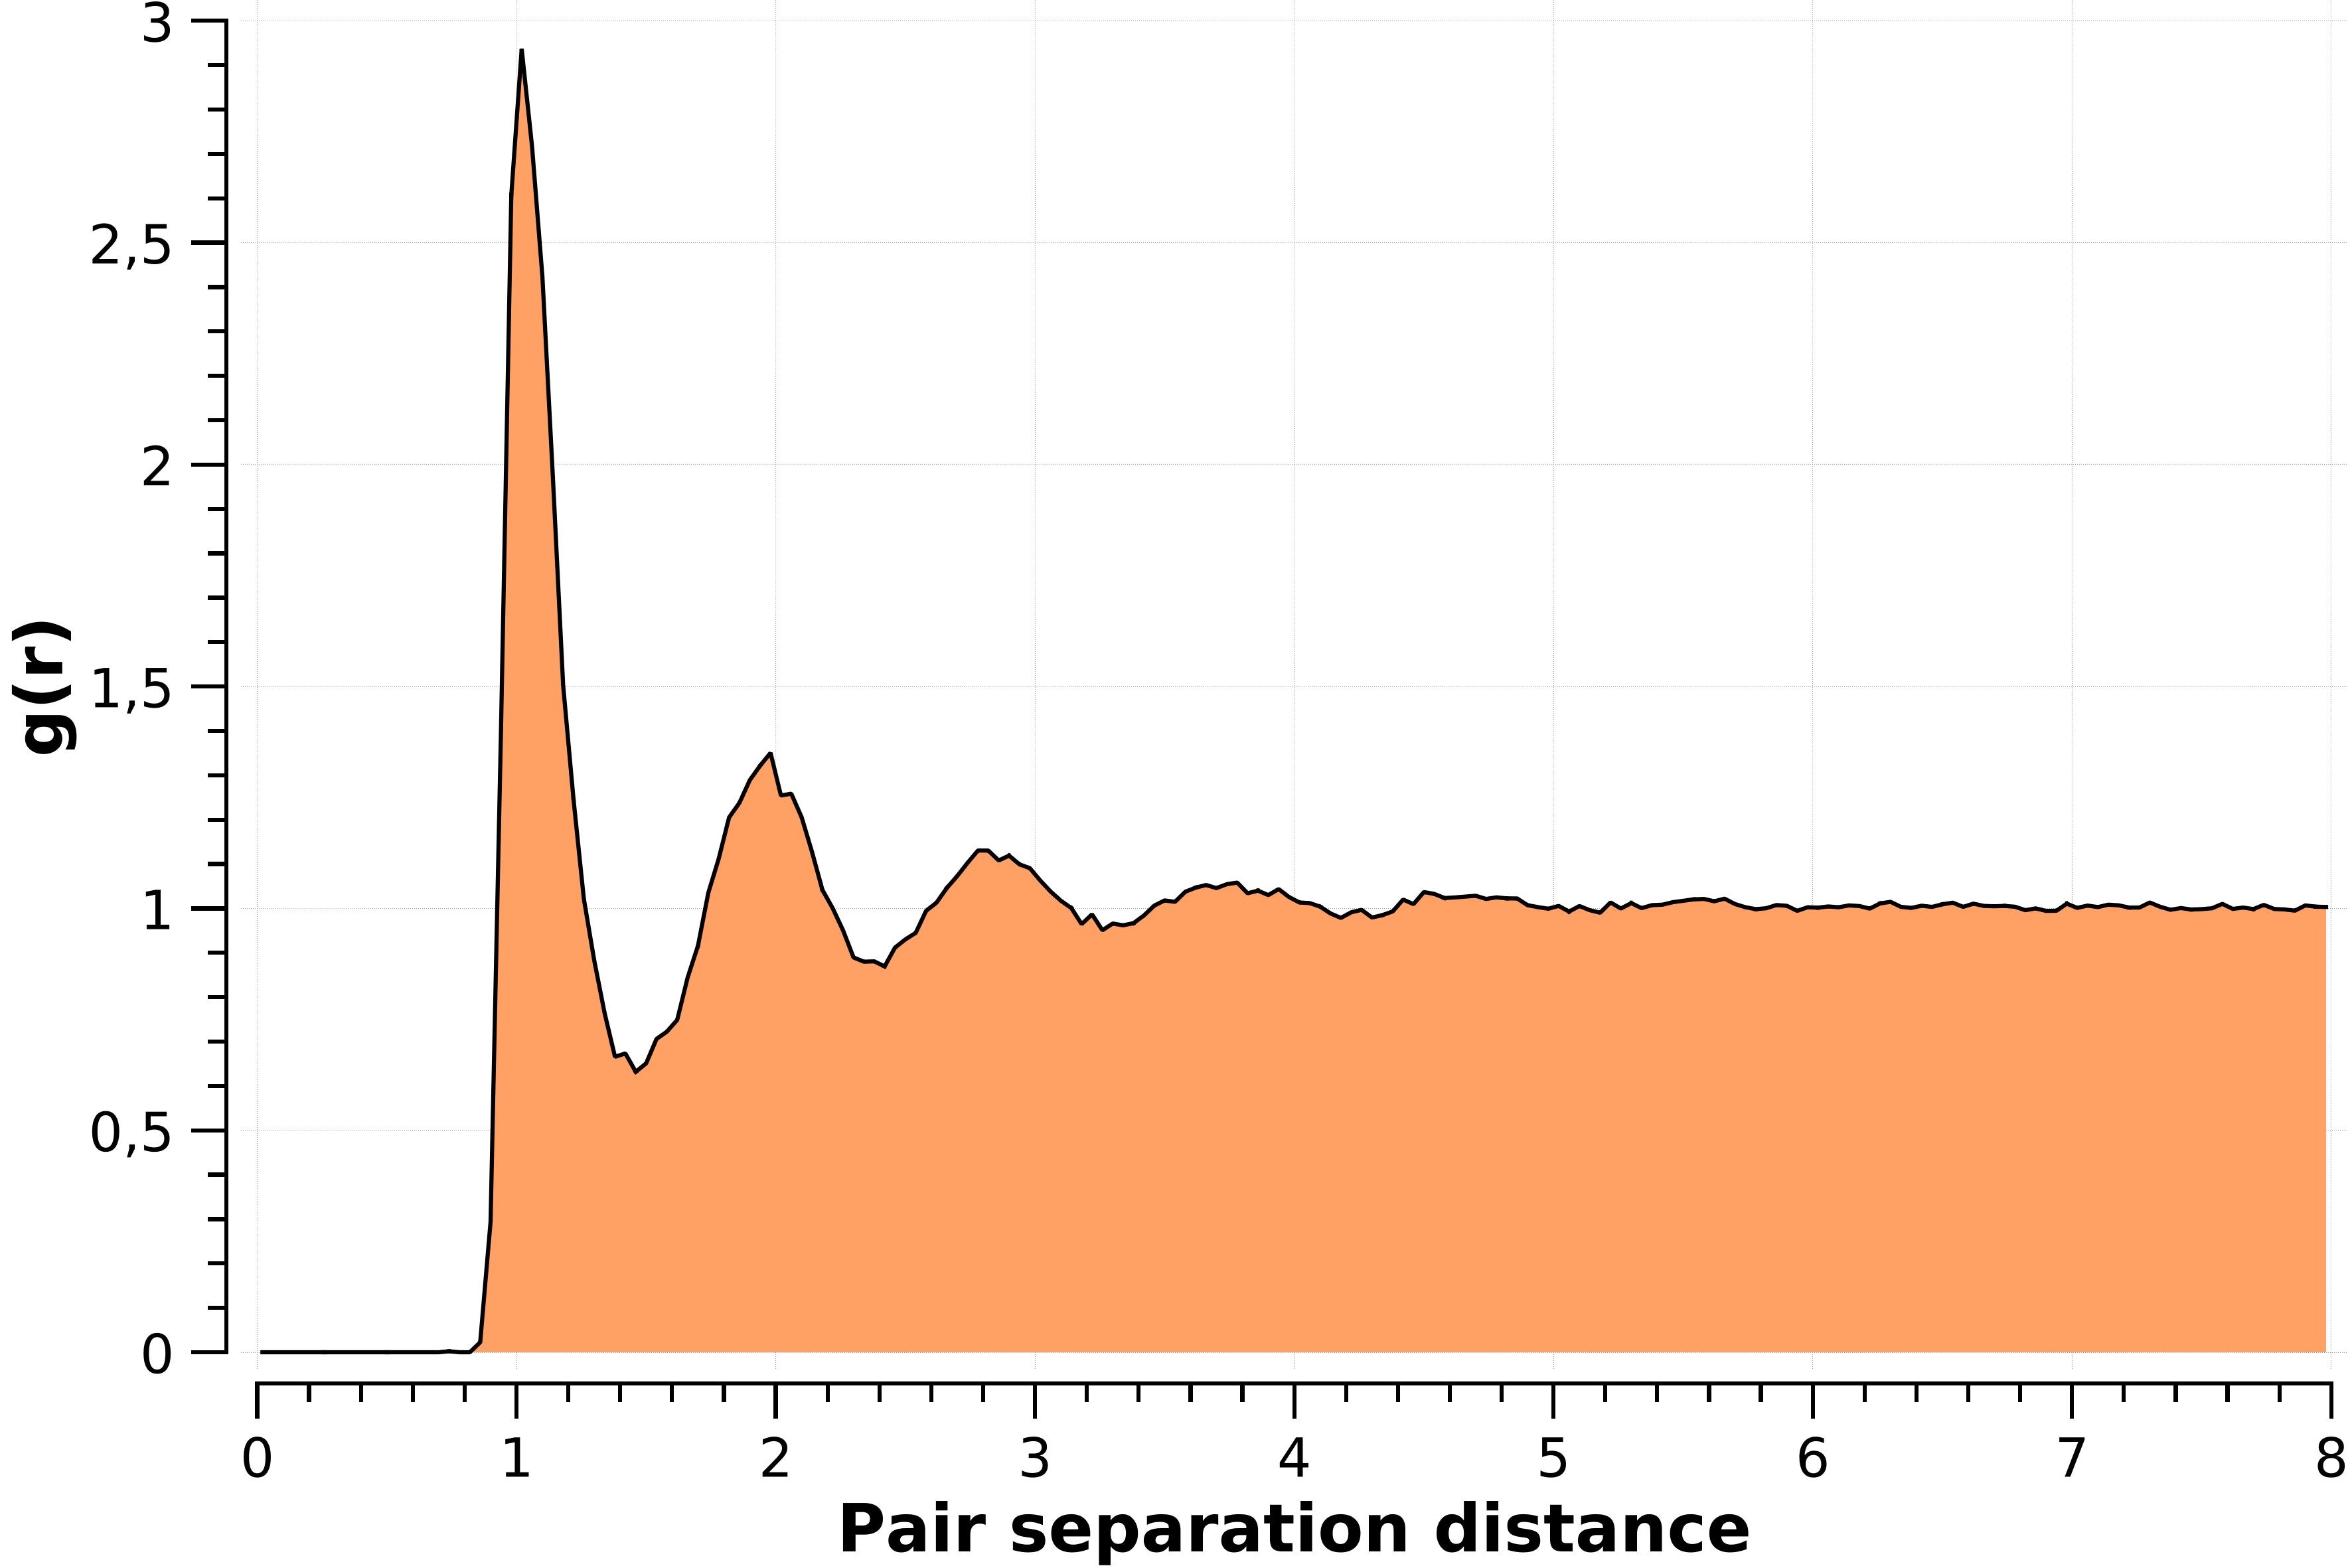

In [23]:
Image(filename="rdf/g(r)_liquid_ovito.png")

### Газ
RDF имеет один пик на 1 и выходит на единицу с 2, что показывает отсутствие структур в газе

In [24]:
df = pd.read_csv("rdf/gas.dat", sep=' ', names= ['x','y','z','vx','vy','vz','1','2','3','4','5','6','7','8'])
del df['1'], df['2'], df['3'], df['4'], df['5'], df['6'], df['7'], df['8']

In [25]:
dr = 0.03
r = np.arange(0, 3.0, dr)
rho = 0.7
#particles = 1024
#cell = 5.675933648*2
particles = 4096
cell = 18.019966087
g = np.zeros(len(r))
x = np.array(df['x'])
y = np.array(df['y'])
z = np.array(df['z'])
for n in tqdm(range(0,particles), desc="Points"):
    x0=x[n]
    y0=y[n]
    z0=z[n]
    rx = x0 - x
    ry = y0 - y
    rz = z0 - z
    rx -= np.rint(rx/cell)*cell
    ry -= np.rint(ry/cell)*cell
    rz -= np.rint(rz/cell)*cell
    rt = np.sqrt(rx*rx+ry*ry+rz*rz)
    rt = np.trunc(rt/dr)
    for j in rt:
        if j<len(g) and j>1:
            rc = j*dr
            g[int(j)]+=1/(4*rho*np.pi*rc*rc*dr)

g = g/particles

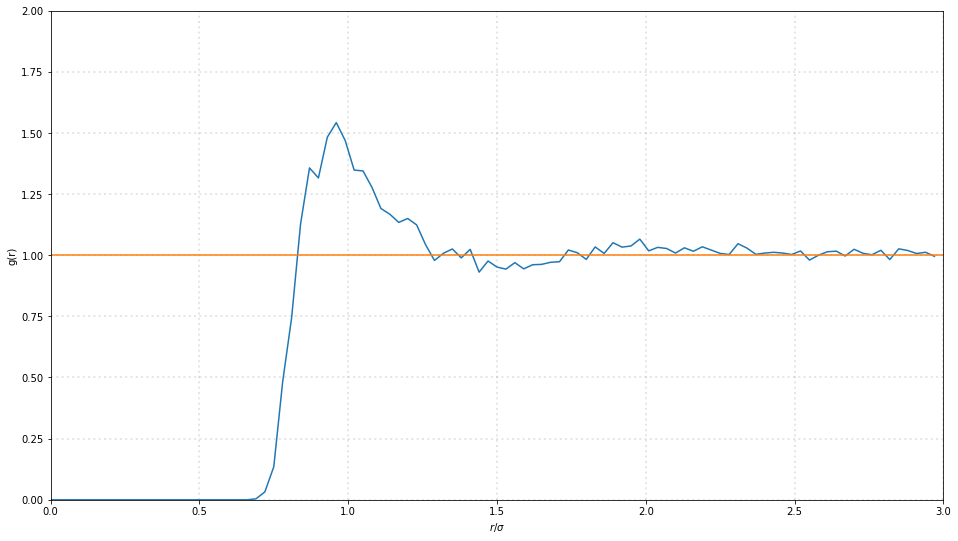

In [26]:
plt.plot(r, g)
plt.plot(np.arange(0, 4, 1), np.ones(4))
plt.rcParams['figure.figsize'] = [16, 9]
plt.grid(b=True, color='Grey', alpha=0.2, linestyle=':', linewidth=2)
plt.xlabel(r"$r/\sigma$")
plt.ylabel("g(r)")
plt.ylim(0,2)
plt.xlim(0,3)
plt.show()